# 0.背景  

## 0.1 目的  
在股市中，投资主要是寻找价值低于当前价格的股票；而投机主要是追趋势低买高卖。  
因此，本主题将尝试利用财务多因子策略选择基本面质地优良且低估最多的股票；而基于趋势追踪确定购买时机。  
## 0.2 相关数据及指标说明  

# 1.模型构建  
* 风险：资产负债率（ALR），应收账款周转率（RTA），存货周转率（ITR），三项费用比（TCR）；（周转率用占比代替）  
* 盈利：毛利率（GPA），净资产收益率（ROE），每股收益（EPS），净利润（NP）；
* 估值：市销率（PS），市净率（PB），市盈率（PE）（LVR），市现率（PCF）;

# 2.研究样本  

* 选取2006-2016年做样本期，进行分析。

# 3.研究过程

## 3.1 获取数据

In [22]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
factors = ['ALR','RTA','ITR','TCR','GPA','ROE','EPS','NP','PS','PB','PE','PCF']

In [24]:
stock_set = [get_index_stocks('000001.XSHG', date =str(i) + '-01-01') for i in range(2006,2016)]

In [25]:
stock_set = DataFrame(stock_set).T

In [26]:
for i in range(10):
    q = query(
    valuation.code,
        
    balance.total_liability/balance.total_assets, # 资产负债率ALR
    balance.account_receivable/income.operating_revenue, # 应收账款占比RTA
    balance.inventories/income.operating_revenue, # 存货占比ITR
    (income.sale_expense + income.administration_expense + income.financial_expense)/income.total_operating_revenue, # 三项费用占比TCR
    
    (income.operating_revenue-income.operating_cost)/income.operating_revenue, # 销售毛利率GPA
    income.net_profit/balance.total_owner_equities, # 净资产收益率ROE
    income.basic_eps, # 每股收益EPS
    income.net_profit, # 净利润NP
        
    valuation.ps_ratio,
    valuation.pb_ratio,
    valuation.pe_ratio_lyr,
    valuation.pcf_ratio    
    ).filter(
        valuation.code.in_(stock_set[i].dropna())
    )

In [27]:
df_jq = [get_fundamentals(q, statDate=str(i)) for i in range(2006,2016)]

In [28]:
for i in range(10):
    df_jq[i].columns= ['code'] + factors
    df2006,df2007,df2008,df2009,df2010,df2011,df2012,df2013,df2014,df2015 = \
    df_jq[0].dropna(),df_jq[1].dropna(),df_jq[2].dropna(),df_jq[3].dropna(),\
    df_jq[4].dropna(),df_jq[5].dropna(),df_jq[6].dropna(),df_jq[7].dropna(),\
    df_jq[8].dropna(),df_jq[9].dropna()
    
#    map(lambda j: ('df'+ str(j)), range(2006,2016)) = df_jq[i]

In [29]:
df2015.head()

,code,ALR,RTA,ITR,TCR,GPA,ROE,EPS,NP,PS,PB,PE,PCF
1,600004.XSHG,0.207073,0.105287,0.013054,0.090902,0.401008,0.132468,1.0900,1294566144,2.90,1.77,15.0458,-23.62
2,600005.XSHG,0.697277,0.190308,0.189428,0.109126,-0.015178,-0.262665,-0.7440,-7510636544,0.48,1.01,27.8546,37.40
3,600006.XSHG,0.596814,0.130904,0.087929,0.138444,0.155154,0.035138,0.1722,286432032,1.11,2.77,126.0459,134.49
4,600007.XSHG,0.446941,0.062320,0.010311,0.100305,0.513255,0.111162,0.6200,628263104,8.41,3.45,35.2591,98.02
5,600008.XSHG,0.673350,0.192903,0.553320,0.235436,0.322998,0.059438,0.2241,701387520,4.38,3.05,40.2486,15.27


In [268]:
#fdf['code'] = map(lambda i: fdf['code'][i][:6] ,np.arange(970))
#df.loc[index_row]

## 3.2 熵值法对各项指标进行评价

熵值法需确定正向和反向指标，根据研究目的，将风险和估值列为负向指标，而将盈利列为正向指标。  
* 风险：资产负债率（ALR），应收账款周转率（RTA），存货周转率（ITR），三项费用比（TCR）；（周转率用占比代替）  
* 盈利：毛利率（GPA），净资产收益率（ROE），每股收益（EPS），净利润（NP）；  
* 估值：市销率（PS），市净率（PB），市盈率（PE）（LVR），市现率（PCF）;

### 3.2.1 熵值法代码

In [30]:
def entropy(X1,X2):
    
    # X1为正向指标，X2为反向指标
    n = X1.shape[0]
    m = X1.shape[1]
    s = X2.shape[1]
    
    # 标准化数据
    #standardized_X1 = 1/(X1.max()-X1.min())*X1 -  X1.min()/(X1.max()-X1.min())
    standardized_X1 = (X1-X1.min()) /(X1.max()-X1.min())
    standardized_X2 = (X2.max()-X2) /(X2.max()-X2.min())
    standardized_X = pd.concat([standardized_X1 , standardized_X2], axis=1)

    # 计算第j项指标第i个方案指标值的比重
    fij = standardized_X/standardized_X.sum()
    
    # 计算第j项指标的熵Hj
    Hj = -sum((fij*log(fij)).dropna())/log(n)
    
    # 计算各指标熵权w
    gj = 1-Hj
    wj = gj/sum(gj)
    #w = wj.sort(ascending=False)
    #wj2 = gj/((m+s)-sum(Hj))
    
    # 计算C矩阵
    C = fij*wj
    
    # 直接求出的结果（越大越好）
    v = sum(C,axis=1)
    
    # 计算距离d（越小越好，与max对比）
    d = sqrt(sum( (C-C.max())**2, axis=1))
    
    # 计算贴进度T（越小越好）
    T = 1- sum( C*C.max(), axis=1) / sum(C.max()**2)
    
    # 对结果进行处理，返回前十只股票的index
    T.sort()
    Top100 = T.head(100).index
    
    # 返回指标权重，Top10的index值
    return wj, Top100

### 3.2.2 按年计算各指标权重，并选出最佳的十只股票

In [31]:
df = [df2006,df2007,df2008,df2009,df2010,df2011,df2012,df2013,df2014,df2015]
wj = np.zeros([len(factors),len(df)])
Topindex = np.zeros([100,len(df)])
Top100 = np.zeros([100,len(df)]).astype(np.object)
for i in range(10):
    wj[:,i], Topindex[:,i] = entropy(df[i][["GPA","ROE","EPS","NP"]],\
                                  df[i][["ALR","RTA",'ITR','TCR','PS','PB','PE','PCF']])
    Top100[:,i] = df[i]["code"].loc[Topindex[:,i]]

In [32]:
wjpd = DataFrame(wj,
                 index=factors,
                 columns=["2006","2007","2008","2009","2010","2011","2012","2013","2014","2015"])

In [33]:
Top100pd = DataFrame(Top100,
                   columns=["2006","2007","2008","2009","2010","2011","2012","2013","2014","2015"])

In [34]:
wjpd

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
ALR,0.091516,0.073294,0.104402,0.074830,0.076672,0.108696,0.121339,0.093987,0.105277,0.131964
RTA,0.078763,0.054697,0.084651,0.078229,0.041191,0.073221,0.095331,0.072168,0.079348,0.072356
ITR,0.080004,0.066741,0.078892,0.076475,0.051040,0.097358,0.088935,0.072432,0.082051,0.077637
TCR,0.123142,0.272497,0.106089,0.143296,0.482668,0.141808,0.114264,0.170573,0.097762,0.115389
GPA,0.075381,0.052230,0.076850,0.078575,0.040129,0.071035,0.073433,0.122295,0.079104,0.097148
ROE,0.076042,0.053293,0.078684,0.079005,0.046877,0.075480,0.071560,0.067602,0.085268,0.074074
EPS,0.078531,0.052794,0.081265,0.077931,0.038712,0.070445,0.076608,0.068605,0.078742,0.072854
NP,0.074618,0.053651,0.070484,0.071178,0.037985,0.057097,0.071148,0.065465,0.073916,0.068771
PS,0.078821,0.053718,0.063451,0.076716,0.038809,0.066414,0.063878,0.063838,0.079478,0.072305
PB,0.078905,0.053733,0.086407,0.085268,0.041262,0.072731,0.074785,0.066065,0.078181,0.073026


In [35]:
Top100pd.head(10)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,600028.XSHG,600028.XSHG,601857.XSHG,601857.XSHG,601857.XSHG,601857.XSHG,601857.XSHG,601857.XSHG,601857.XSHG,600028.XSHG
1,600019.XSHG,601919.XSHG,600050.XSHG,600028.XSHG,600028.XSHG,600028.XSHG,600028.XSHG,600028.XSHG,601088.XSHG,601857.XSHG
2,600362.XSHG,600019.XSHG,601088.XSHG,601088.XSHG,601088.XSHG,601088.XSHG,601088.XSHG,601088.XSHG,600028.XSHG,600104.XSHG
3,601111.XSHG,601600.XSHG,600028.XSHG,600050.XSHG,600104.XSHG,600104.XSHG,600104.XSHG,600104.XSHG,600519.XSHG,601668.XSHG
4,600005.XSHG,600385.XSHG,601919.XSHG,601668.XSHG,601668.XSHG,601668.XSHG,600519.XSHG,601668.XSHG,600104.XSHG,600519.XSHG
5,600900.XSHG,600050.XSHG,601898.XSHG,600104.XSHG,600019.XSHG,600519.XSHG,601668.XSHG,600519.XSHG,601668.XSHG,601088.XSHG
6,600050.XSHG,600005.XSHG,600188.XSHG,601390.XSHG,601111.XSHG,600585.XSHG,600900.XSHG,600011.XSHG,601006.XSHG,600011.XSHG
7,600026.XSHG,600104.XSHG,600519.XSHG,601898.XSHG,600188.XSHG,601898.XSHG,600048.XSHG,601006.XSHG,600048.XSHG,600048.XSHG
8,600808.XSHG,600900.XSHG,600019.XSHG,601186.XSHG,601390.XSHG,600031.XSHG,601800.XSHG,600048.XSHG,600900.XSHG,600900.XSHG
9,600875.XSHG,601991.XSHG,600026.XSHG,600019.XSHG,600900.XSHG,600188.XSHG,601898.XSHG,601800.XSHG,600585.XSHG,601800.XSHG


### 3.2.3 分析

#### 指标分析  

1.权重上升的指标：  
  * ALR：资产负债率
  * GPA：毛利率  
  
2.权重下降的指标：  
  *  PCF：市现率   
    
3.TCR（三项费用占比）指标波动明显。

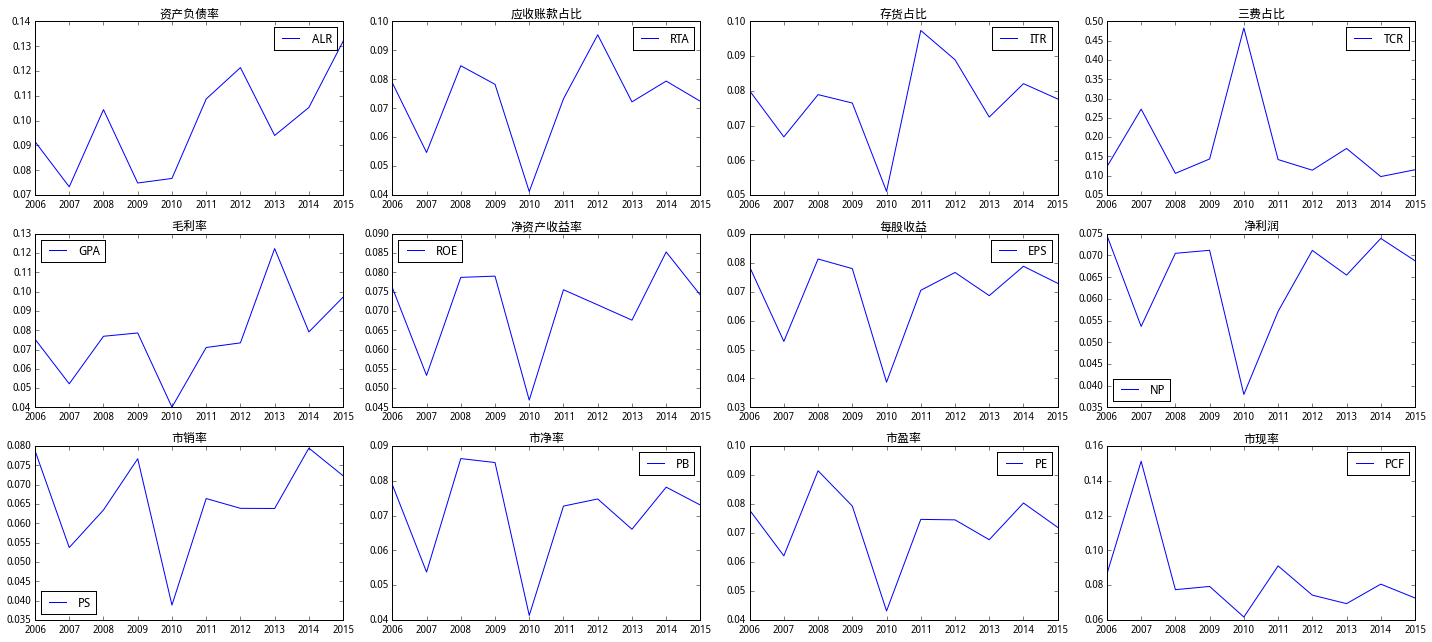

In [38]:
fig, axes = plt.subplots(3,4, figsize=(20,9))

wjpd.ix["ALR"].plot(ax=axes[0,0])
axes[0,0].set_title('资产负债率')
wjpd.ix["RTA"].plot(ax=axes[0,1])
axes[0,1].set_title('应收账款占比')
wjpd.ix["ITR"].plot(ax=axes[0,2])
axes[0,2].set_title('存货占比')
wjpd.ix["TCR"].plot(ax=axes[0,3])
axes[0,3].set_title('三费占比')

wjpd.ix["GPA"].plot(ax=axes[1,0])
axes[1,0].set_title('毛利率')
wjpd.ix["ROE"].plot(ax=axes[1,1])
axes[1,1].set_title('净资产收益率')
wjpd.ix["EPS"].plot(ax=axes[1,2])
axes[1,2].set_title('每股收益')
wjpd.ix["NP"].plot(ax=axes[1,3])
axes[1,3].set_title('净利润')

wjpd.ix["PS"].plot(ax=axes[2,0])
axes[2,0].set_title('市销率')
wjpd.ix["PB"].plot(ax=axes[2,1])
axes[2,1].set_title('市净率')
wjpd.ix["PE"].plot(ax=axes[2,2])
axes[2,2].set_title('市盈率')
wjpd.ix["PCF"].plot(ax=axes[2,3])
axes[2,3].set_title('市现率')

for i in range(3):
    for j in range(4):
        
        axes[i,j].legend(loc=0,fontsize=12)    

fig.tight_layout()

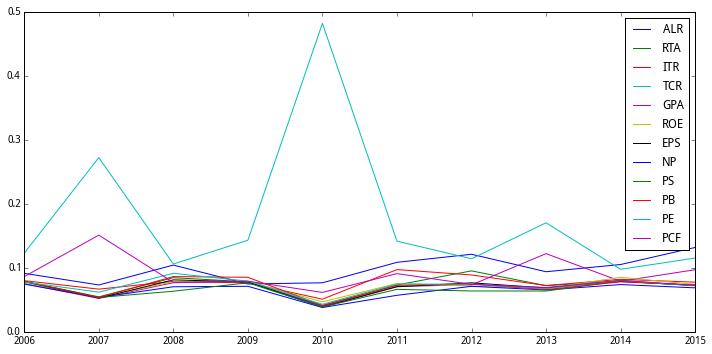

In [109]:
fig, ax = plt.subplots(1,1, figsize=(10,5))


for i in range(12):
    wjpd.ix[i].plot(ax=ax)
    ax.legend(loc=0,fontsize=12)    

fig.tight_layout()

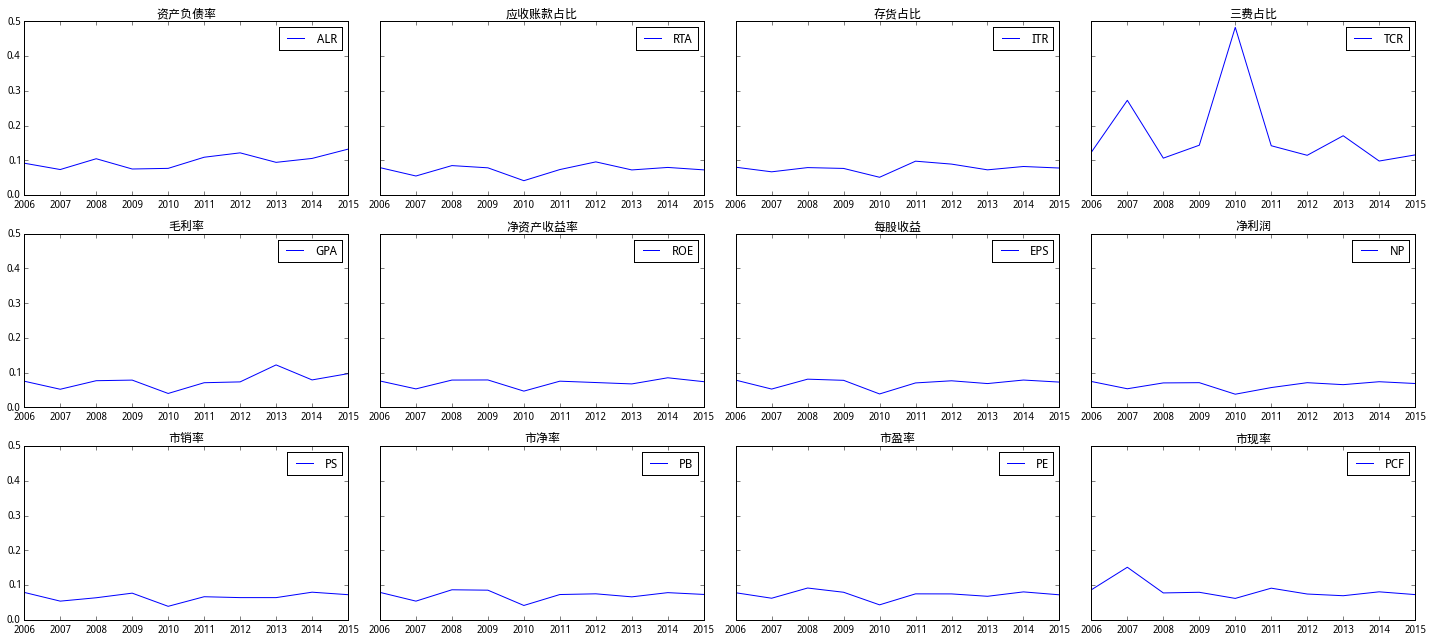

In [39]:
fig, axes = plt.subplots(3,4, figsize=(20,9),sharey=True)

wjpd.ix["ALR"].plot(ax=axes[0,0])
axes[0,0].set_title('资产负债率')
wjpd.ix["RTA"].plot(ax=axes[0,1])
axes[0,1].set_title('应收账款占比')
wjpd.ix["ITR"].plot(ax=axes[0,2])
axes[0,2].set_title('存货占比')
wjpd.ix["TCR"].plot(ax=axes[0,3])
axes[0,3].set_title('三费占比')

wjpd.ix["GPA"].plot(ax=axes[1,0])
axes[1,0].set_title('毛利率')
wjpd.ix["ROE"].plot(ax=axes[1,1])
axes[1,1].set_title('净资产收益率')
wjpd.ix["EPS"].plot(ax=axes[1,2])
axes[1,2].set_title('每股收益')
wjpd.ix["NP"].plot(ax=axes[1,3])
axes[1,3].set_title('净利润')

wjpd.ix["PS"].plot(ax=axes[2,0])
axes[2,0].set_title('市销率')
wjpd.ix["PB"].plot(ax=axes[2,1])
axes[2,1].set_title('市净率')
wjpd.ix["PE"].plot(ax=axes[2,2])
axes[2,2].set_title('市盈率')
wjpd.ix["PCF"].plot(ax=axes[2,3])
axes[2,3].set_title('市现率')

for i in range(3):
    for j in range(4):
        
        axes[i,j].legend(loc=0,fontsize=12)    

fig.tight_layout()

#### 股票分析
1.我们将十年内每年排名前100的股票按出现次数排名，得到的股票很可能就是符合我们条件的公司。
经查，对应公司如下：  
雅戈尔  
长江电力  
金地集团  
中石化  
海螺水泥  
贵州茅台  
青岛海尔  
山东高速  
宁沪高速  
保利地产  
中国联通

In [95]:
stock_choose = DataFrame(Top100.reshape(1000,1))[0].value_counts()
stock_choose.head(50)

600177.XSHG    10
600900.XSHG    10
600383.XSHG    10
600028.XSHG    10
600585.XSHG    10
600519.XSHG    10
600690.XSHG    10
600350.XSHG    10
600377.XSHG    10
600048.XSHG    10
600050.XSHG    10
600019.XSHG     9
600196.XSHG     9
600600.XSHG     9
601111.XSHG     9
600660.XSHG     9
600309.XSHG     9
600104.XSHG     9
600795.XSHG     9
600663.XSHG     9
601088.XSHG     8
601857.XSHG     8
601808.XSHG     8
600362.XSHG     8
601727.XSHG     8
600276.XSHG     8
601390.XSHG     8
600031.XSHG     8
601186.XSHG     8
601699.XSHG     8
601766.XSHG     8
600886.XSHG     7
600188.XSHG     7
600875.XSHG     7
600649.XSHG     7
600887.XSHG     7
600741.XSHG     7
600153.XSHG     7
600266.XSHG     7
600809.XSHG     7
600269.XSHG     7
600376.XSHG     7
601668.XSHG     7
600123.XSHG     7
601899.XSHG     6
600295.XSHG     6
600271.XSHG     6
600150.XSHG     6
601299.XSHG     6
600588.XSHG     6
dtype: int64

**转为公司名称**

In [44]:
import tushare as ts

stocks = ts.get_stock_basics()
stocks.head(3)

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,reservedPerShare,esp,bvps,pb,timeToMarket
code,,,,,,,,,,,,,,,
300522,N世名,染料涂料,江苏,35.67,1667.00,6667.0,33517.85,17482.50,4053.37,1882.30,0.28,0.187,4.41,6.05,20160705
300521,N爱司凯,专用机械,广东,55.22,2000.00,8000.0,29108.21,25952.76,1344.95,3513.45,0.44,0.073,3.93,4.12,20160705
000426,兴业矿业,铅锌,内蒙,0.00,96326.54,119388.9,432047.19,82100.34,132588.25,84317.49,0.71,-0.003,2.26,4.17,19960828


In [70]:
stock_choose.shape

(288,)

In [107]:
stock_choose_index = map(lambda i: stock_choose.index[i][:6] ,np.arange(288))

In [121]:
stock_choose.index = stock_choose_index

In [124]:
stock_choose.head()

600177    10
600900    10
600383    10
600028    10
600585    10
dtype: int64

In [111]:
companies = stocks['name'].loc[stock_choose_index]

In [125]:
companies.head()

code
600177     雅戈尔
600900    长江电力
600383    金地集团
600028    中国石化
600585    海螺水泥
Name: name, dtype: object

In [129]:
mystock_choose = pd.concat([companies,stock_choose], axis=1) 
mystock_choose.columns = ['company','counts']
mystock_choose.head(20)

,company,counts
code,,
600177,雅戈尔,10
600900,长江电力,10
600383,金地集团,10
600028,中国石化,10
600585,海螺水泥,10
600519,贵州茅台,10
600690,青岛海尔,10
600350,山东高速,10
600377,宁沪高速,10


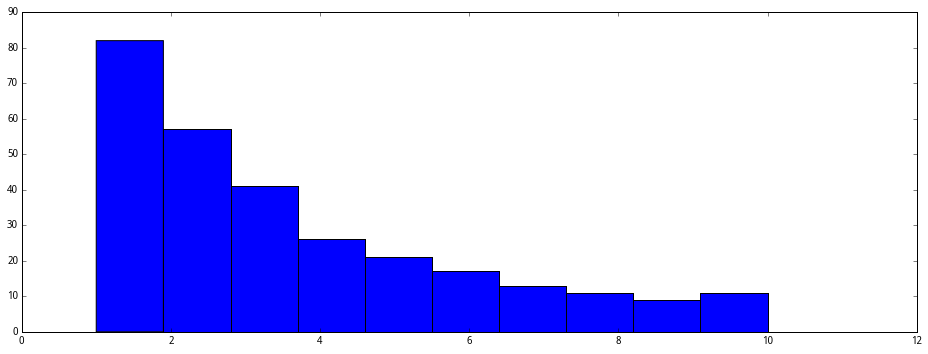

In [142]:
fig, ax = plt.subplots(1,1, figsize=(13,5))

ax.hist(mystock_choose['counts'])

fig.tight_layout()

2.通过上面的分析，我们发现找出来的公司的确是比较优秀的公司，但基本也都时大盘股。可能也与板块、概念等有关。

**2015年的情况：**

In [179]:
Top100pd["2015"].head(20)

0     600028.XSHG
1     601857.XSHG
2     600104.XSHG
3     601668.XSHG
4     600519.XSHG
5     601088.XSHG
6     600011.XSHG
7     600048.XSHG
8     600900.XSHG
9     601800.XSHG
10    601006.XSHG
11    601766.XSHG
12    600886.XSHG
13    601186.XSHG
14    601390.XSHG
15    600050.XSHG
16    600018.XSHG
17    600585.XSHG
18    601633.XSHG
19    600276.XSHG
Name: 2015, dtype: object

##### 按市值排序，找出2015年中的小盘股（市值小于20亿元）：  
结果发现并没有满足条件的股票。

In [183]:
mystock_set_little = Top100pd["2015"]

In [185]:
# 选出所有的总市值小于20亿元, 市盈率小于10的股票

mydf_little = get_fundamentals(query(
        valuation.code, 
        valuation.market_cap<20, 
        valuation.pe_ratio<10
    ).filter(
        # 这里不能使用 in 操作, 要使用in_()函数
        valuation.code.in_(mystock_set_little)
    ).order_by(
        # 按市值升序排列
        valuation.market_cap
    ).limit(
        # 最多返回100个
        10
    ), date='2016-01-01')

mydf_little.columns=['code','market_cap','pe_ratio']
mydf_little

,code,market_cap,pe_ratio
0,600543.XSHG,0,0
1,603518.XSHG,0,0
2,600779.XSHG,0,1
3,600599.XSHG,0,1
4,603099.XSHG,0,0
5,600258.XSHG,0,0
6,600285.XSHG,0,0
7,603998.XSHG,0,0
8,600358.XSHG,0,1
9,601188.XSHG,0,0


##### 将结果按市盈率排序，可以发现一些市盈率比较低的公司：  
熊猫金控  
国旅联合  
水井坊  
中国建筑  
广日股份  
上汽集团  
雅戈尔  
大秦铁路  
保利地产  
华域汽车

In [186]:
mydf_low = get_fundamentals(query(
        valuation.code, 
        valuation.market_cap<20, 
        valuation.pe_ratio<10
    ).filter(
        # 这里不能使用 in 操作, 要使用in_()函数
        valuation.code.in_(mystock_set_little)
    ).order_by(
        # 按市盈率升序排列
        valuation.pe_ratio
    ).limit(
        # 最多返回100个
        11
    ), date='2016-01-01')

mydf_low

,code,anon_1,anon_2
0,600599.XSHG,0,1
1,600358.XSHG,0,1
2,600779.XSHG,0,1
3,601668.XSHG,0,1
4,600894.XSHG,0,1
5,600104.XSHG,0,1
6,600177.XSHG,0,1
7,601006.XSHG,0,1
8,600048.XSHG,0,1
9,600741.XSHG,0,1


**1.对比15年底和16年6月底的市盈率和市值**

In [187]:
stock_set_con = mydf_low['code'].head(10)

In [190]:
stock_set_con.sort()
stock_set_con

8    600048.XSHG
5    600104.XSHG
6    600177.XSHG
1    600358.XSHG
0    600599.XSHG
9    600741.XSHG
2    600779.XSHG
4    600894.XSHG
7    601006.XSHG
3    601668.XSHG
Name: code, dtype: object

In [191]:
mydf1 = get_fundamentals(query(
        valuation.code, 
        valuation.market_cap, 
        valuation.pe_ratio
    ).filter(
        # 这里不能使用 in 操作, 要使用in_()函数
        valuation.code.in_(stock_set_con)
    ), date='2016-01-01')

mydf2 = get_fundamentals(query(
        valuation.code, 
        valuation.market_cap, 
        valuation.pe_ratio
    ).filter(
        # 这里不能使用 in 操作, 要使用in_()函数
        valuation.code.in_(stock_set_con)
    ), date='2016-07-01')

pd.concat([mydf1,mydf2], axis=1) 

,code,market_cap,pe_ratio,code,market_cap,pe_ratio
0,600048.XSHG,1144.3600,9.09,600048.XSHG,1016.03,8.1800
1,600104.XSHG,2339.6299,8.12,600104.XSHG,2247.01,7.4300
2,600177.XSHG,362.4900,8.14,600177.XSHG,351.49,6.4700
3,600358.XSHG,73.4400,-75.38,600358.XSHG,68.17,-7047.7202
4,600599.XSHG,62.4500,-1285.11,600599.XSHG,43.31,227.8400
5,600741.XSHG,435.5300,9.42,600741.XSHG,443.90,9.2000
6,600779.XSHG,62.2400,-29.96,600779.XSHG,81.83,69.2600
7,600894.XSHG,171.9000,7.91,600894.XSHG,115.23,5.3700
8,601006.XSHG,1281.5200,9.02,601006.XSHG,957.42,8.7100
9,601668.XSHG,1902.0000,7.70,601668.XSHG,1590.00,5.9300


**2.对比15年底和16年6月底的股价**

In [260]:
security = mydf_low['code'].head(10)

In [261]:
security.sort()
security

8    600048.XSHG
5    600104.XSHG
6    600177.XSHG
1    600358.XSHG
0    600599.XSHG
9    600741.XSHG
2    600779.XSHG
4    600894.XSHG
7    601006.XSHG
3    601668.XSHG
Name: code, dtype: object

In [284]:
close1 = np.zeros(10)
close2 = np.zeros(10)

for i in range(10):
    close1[i] = get_price(security[i], start_date='2016-01-01', end_date='2016-07-01', \
                          frequency='daily', fields=None, skip_paused=False, fq='pre')['close'][0]
    close2[i] = get_price(security[i], start_date='2016-01-01', end_date='2016-07-01', \
                          frequency='daily', fields=None, skip_paused=False, fq='pre')['close'][-1]

close1 = DataFrame(close1)
close2 = DataFrame(close2)
secruity = DataFrame(security)
price = pd.concat([security,close1,close2], axis=1) 
price.columns=['code','close20160104','close20160701']
price['rate'] = (price['close20160701']-price['close20160104'])/price['close20160104']
price

,code,close20160104,close20160701,rate
0,600599.XSHG,33.80,26.09,-0.228107
1,600358.XSHG,15.30,13.50,-0.117647
2,600779.XSHG,12.10,16.75,0.384298
3,601668.XSHG,5.78,5.30,-0.083045
4,600894.XSHG,17.15,13.40,-0.218659
5,600104.XSHG,19.73,20.38,0.032945
6,600177.XSHG,13.97,13.74,-0.016464
7,601006.XSHG,8.35,6.44,-0.228743
8,600048.XSHG,9.26,8.57,-0.074514
9,600741.XSHG,14.80,14.08,-0.048649


**同期大盘情况：**

In [287]:
XSHG = get_price('000001.XSHG', start_date='2016-01-01', end_date='2016-07-01', \
                 frequency='daily', fields=None, skip_paused=False, fq='pre')['close']

(XSHG[-1]-XSHG[0])/XSHG[0]

-0.11036217432009256

In [286]:
XSHG[0],XSHG[-1]

(3296.2579999999998, 2932.4758000000002)

### 3.2.4 结论  
选出来的基本都是大盘股，大部分企业经营业绩良好，但盘子太大，不受资本市场青睐。因此，这些股票的业绩并不是很好。  

## 3.3 模型构建  

用各指标十年权重平均值作为模型权重。  
**综合评分=**
$ 0.1767*TCR + 0.0982*ALR + 0.0843*PCF + 0.0772*ITR + \
  0.0766*GPA + 0.073*RTA + 0.0723*PE + 0.071*PB + \
  0.0708*ROE + 0.0696*EPS + 0.0657*PS + 0.0644*NP $

In [331]:
mywj = wjpd.sum(axis=1)/10

In [332]:
mywj.sort(ascending=False)
mywj

TCR    0.176749
ALR    0.098198
PCF    0.084341
ITR    0.077157
GPA    0.076618
RTA    0.072996
PE     0.072295
PB     0.071036
ROE    0.070788
EPS    0.069649
PS     0.065743
NP     0.064431
dtype: float64

## 3.4 模型应用

In [318]:
factors = ['ALR','RTA','ITR','TCR','GPA','ROE','EPS','NP','PS','PB','PE','PCF']
stock_set = get_index_stocks('000001.XSHG', date ='2016-07-01')

q = query(
    valuation.code,
        
    balance.total_liability/balance.total_assets, # 资产负债率ALR
    balance.account_receivable/income.operating_revenue, # 应收账款占比RTA
    balance.inventories/income.operating_revenue, # 存货占比ITR
    (income.sale_expense + income.administration_expense + income.financial_expense)/income.total_operating_revenue, # 三项费用占比TCR
    
    (income.operating_revenue-income.operating_cost)/income.operating_revenue, # 销售毛利率GPA
    income.net_profit/balance.total_owner_equities, # 净资产收益率ROE
    income.basic_eps, # 每股收益EPS
    income.net_profit, # 净利润NP
        
    valuation.ps_ratio,
    valuation.pb_ratio,
    valuation.pe_ratio_lyr,
    valuation.pcf_ratio    
    ).filter(
        valuation.code.in_(stock_set)
    )
    
df = get_fundamentals(q, date='2016-07-01')
df.columns= ['code'] + factors
df = df.dropna()
df_yc = df.drop(df.columns[[0]],axis=1)

In [335]:
mywj_yc = wjpd.sum(axis=1)/10

In [336]:
result = sum(df_yc*mywj_yc,axis=1)
result.sort(ascending = False)
df.loc[result.index].head(10)

,code,ALR,RTA,ITR,TCR,GPA,ROE,EPS,NP,PS,PB,PE,PCF
82,600104.XSHG,0.571480,0.197456,0.226521,0.095455,0.125804,0.050694,0.7200,11373264896,0.33,1.22,7.5419,17.1900
21,600028.XSHG,0.430127,0.096568,0.334808,0.077873,0.242879,0.011331,0.0510,9025000448,0.29,0.83,17.6680,-63.5600
894,601668.XSHG,0.771562,0.622108,1.861774,0.027951,0.105073,0.033509,0.2100,8288527872,0.18,0.91,6.1009,2.7400
822,601088.XSHG,0.343160,0.652327,0.364068,0.145881,0.403127,0.017966,0.2320,6563999744,1.61,0.95,17.4946,50.8600
79,600100.XSHG,0.553639,1.563845,2.091688,0.272720,0.175931,0.202902,1.7552,5246010880,1.62,2.00,36.2032,7.0700
422,600519.XSHG,0.217765,0.000023,1.855869,0.104612,0.923414,0.073470,3.8900,5212078592,10.29,5.22,23.1880,23.8300
8,600011.XSHG,0.659657,0.425206,0.178903,0.089521,0.317287,0.049277,0.2600,4996156928,0.94,1.38,8.3907,15963.9004
22,600029.XSHG,0.717771,0.104848,0.060944,0.101740,0.220305,0.057479,0.2700,3024999936,0.61,1.65,17.7690,-6.2900
829,601111.XSHG,0.683555,0.129772,0.071526,0.114960,0.240918,0.041549,0.2000,2882344960,0.81,1.43,13.0963,105.6400
93,600115.XSHG,0.787501,0.101768,0.088340,0.108226,0.212714,0.070248,0.2000,2831000064,0.91,2.30,19.0404,-283.4800


## 3.5 购买时机  

* 利用RSI和均线判断。  
* 对排名前10的股票进行回测：  
600104.XSHG  
600028.XSHG  
601668.XSHG  
601088.XSHG  
600100.XSHG  
600519.XSHG  
600011.XSHG  
600029.XSHG  
601111.XSHG  
600115.XSHG  

In [18]:
import numpy as np
import pandas as pd
import talib
import datetime

def set_buyableList(context):
    #使用2016年数据选出的股票
    stockList = list(['600104.XSHG','600028.XSHG','601668.XSHG','601088.XSHG','600100.XSHG',\
              '600519.XSHG','600011.XSHG','600029.XSHG','601111.XSHG','600115.XSHG'])
    #第一步，取list中etf过去几天总成交量组成array
    vol4CheckArray = np.array([])
    for security in stockList:
        his = attribute_history(security, g.period4Check, '1d', ('volume'), df = False)
        volumeArray = his['volume']
        volSum = np.sum(volumeArray)
        vol4CheckArray = np.append(vol4CheckArray, volSum)
    #第二步，用stockList做index，上述array做列，构建一个series，
    #按照高到低排序，取前poolSize名，组建新的stockList
    vol4CheckSeries = pd.Series(vol4CheckArray, index = np.array(stockList))
    vol4CheckSeries.sort(ascending = False)
    #poolSize = int( len(stockList) / 10) + 1
    #if poolSize < 10:
    #    poolSize = 10
    poolSize = 5
    stockList = list(vol4CheckSeries.index)[0 : poolSize]
    #计算stockList中的etf过去g.period4Check天的累积收益率比日收益标准差
    #返回比值最大的那只，存入stockList
    ret4CheckArray = np.array([])
    for security in stockList:
        his = attribute_history(security, g.period4Check + 1, '1d', ('close'), df = False)
        closeArray = his['close']
        tempRet = 100 * (closeArray[-1]/closeArray[0] - 1)
        real = talib.ROC(closeArray, timeperiod = 1)
        real = real[-g.period4Check:]
        std = np.std(real)
        ret = tempRet / std
        ret4CheckArray = np.append(ret4CheckArray, ret)
    #构建series，取收益比标准差最大那只存入stockList
    ret4CheckSeries = pd.Series(ret4CheckArray, index = np.array(stockList))
    ret4CheckSeries.sort(ascending = False)
    stockList = list(ret4CheckSeries.index)[0:1]
    g.buyableList = stockList
    #print g.buyableList

####各种初始化####=====================================================
def initialize(context):
    set_option('use_real_price', True)
    set_benchmark('000300.XSHG')
    set_commission(PerTrade(buy_cost = 0.0003, sell_cost = 0.0003, min_cost = 0))
    set_slippage(PriceRelatedSlippage(0.002))
    log.set_level('order', 'error')
    g.buyableList = []
    g.buyDict = {}#该dict每天09:20更新，键是今日需买入的股票代码，值是target_value
    g.sellDict = {}#同上
    ####每周期开始的那天的09:20，获取这一周期内能买的股票####
    ####它们被保存在g.buyableList中####
    run_daily(set_buyableList, 'before_open')
    g.period4Check = 6   #6 
    g.onMarketDays = 146 #146*(250/365)=100，保证上市时间足够长
    ####每天09:20择时所用参数####
    g.nRSI = 6 #计算gapRSI所用天数  #6
    g.buyThreshold = 40 #买入的阈值 #40
    g.sellThreshold = 55 #卖出的阈值#55
    g.ma = 23 #23用这么多日均线判断强弱市，昨收在均线上说明是强市
    #用k线实体长度占总长度的比例来判断是否是变盘点，当比例小于
    #g.bian时，表示k线形态为十字星，表示将要变盘
    #g.bian1和g.bian2分别是弱市和强市情况下的变盘阈值             
    g.bian1 , g.bian2 = 0.8, 0.6



####此函数输入为一个股票代码，应卖出时输出-1，应买进时输出1####
def buyOrSellCheck(security, context):
    panduan = 0
    his = attribute_history(security, 100, '1d', ('open', 'low', 'close', 'high'), df = False)
    closeArray = his['close']
    highArray = his['high']
    openArray = his['open']
    lowArray = his['low']
    ####计算MA####
    MAArray = talib.EMA(closeArray, g.ma)
    ####a用来计算k线的实体部分长度占总长度的比例
    #a越小，说明是十字星形状的k线，说明要变盘####
    a = (openArray[-1] - closeArray[-1]) / (highArray[-1] - lowArray[-1])
    a = abs(a)
    ####计算择时主要指标jump-RSI####
    jumpArray = talib.LN(closeArray / highArray)
    RSIArray = talib.RSI(jumpArray, g.nRSI)
    ####根据jump-RSI择时####
    if RSIArray[-1] <= g.buyThreshold:#RSI低于买入阈值
        if closeArray[-1] > MAArray[-1]:#判断强弱市
            panduan = 1
        elif a <= g.bian1:#弱市状态下，需要确认有变盘信号才买进
            panduan = 1
    elif RSIArray[-1] >= g.sellThreshold:#RSI高于卖出阈值
        if closeArray[-1] <= MAArray[-1]:
            panduan = -1
        elif a <= g.bian2:#强市状态下，需要确认有变盘信号才卖出
            panduan = -1
    ####止盈止损####
    if security in context.portfolio.positions.keys():
        avgCost = context.portfolio.positions[security].avg_cost
        if closeArray[-1]/avgCost - 1 < -0.1:
            panduan = -1
        if closeArray[-1]/avgCost - 1 > 0.1:
            panduan = -1
    return panduan

####每天开盘前####
def before_trading_start(context):
    #初始化买卖两个字典
    #字典的键是需要买和卖的股票，值是调仓的target_value
    g.sellDict = {}
    g.buyDict = {}
    #如果现持仓为空
    if context.portfolio.positions.keys() == []:
        #判断buyableList中的股票需不需要买进
        security = g.buyableList[0]
        panduan = buyOrSellCheck(security, context)
        if panduan == 1:
            g.buyDict[security] = context.portfolio.portfolio_value
    #现持仓不为空
    else:
        security1 = context.portfolio.positions.keys()[0]
        security2 = g.buyableList[0]
        #判断现持仓需不需要卖出
        panduan1 = buyOrSellCheck(security1, context)
        panduan2 = buyOrSellCheck(security2, context)
        if panduan1 == -1:
            g.sellDict[security1] = 0
            #判断buyableList中的股票需不需要买进
            if panduan2 == 1:
                g.buyDict[security2] = context.portfolio.portfolio_value*1.1
     
    if g.sellDict != {}:
        message = 'SELL ' + g.sellDict.keys()[0]
        print message
        send_message(message, channel = 'weixin')
    if g.buyDict != {}:
        message = 'BUY ' + g.buyDict.keys()[0]    
        print message
        send_message(message, channel = 'weixin')

# 开盘后
def handle_data(context, data):
    for security in g.sellDict:
        order_target_value(security, g.sellDict[security])
    for security in g.buyDict:
        order_target_value(security, g.buyDict[security])

* [利用熵值法根据2016年数据选出的股票进行回测](http://o9sx3fme2.bkt.clouddn.com/%E5%AF%B9%E5%88%A9%E7%94%A8%E7%86%B5%E5%80%BC%E6%B3%95%E6%A0%B9%E6%8D%AE2016%E5%B9%B4%E6%95%B0%E6%8D%AE%E9%80%89%E5%87%BA%E7%9A%84%E8%82%A1%E7%A5%A8%E8%BF%9B%E8%A1%8C%E5%9B%9E%E6%B5%8B.png)  
* [利用熵值法根据2006-2015年数据选出的股票进行预测（用2016年实际情况预测）](http://o9sx3fme2.bkt.clouddn.com/%E5%AF%B9%E5%88%A9%E7%94%A8%E7%86%B5%E5%80%BC%E6%B3%95%E6%A0%B9%E6%8D%AE2006-2015%E5%B9%B4%E6%95%B0%E6%8D%AE%E9%80%89%E5%87%BA%E7%9A%84%E8%82%A1%E7%A5%A8%E8%BF%9B%E8%A1%8C%E9%A2%84%E6%B5%8B%EF%BC%88%E7%94%A82016%E5%B9%B4%E5%AE%9E%E9%99%85%E6%83%85%E5%86%B5%E9%A2%84%E6%B5%8B%EF%BC%89.png)

可以发现，虽然收益比基准要好，但用前10年数据选出来的股票池还是有些“过时”。相反，用2016年数据选出来的股票池要好很多。

# 4.总结

### 有关本案例

* 选股结果在分析前基本有了大致判断，此过程更多的是验证，想看看中间到底是怎么回事。  
* 在确定权重时，应该再尝试剔除大盘股后看结果如何。因为大盘股指标突出，再加上“熵值法”本身的特性，会导致权重偏向大盘股。  
* 由于数据获取难度，没有考虑“增长指标”，如：总资产增长率（TAR），净利润增长率（NPR），每股收益增长率（PSER），股东权益增长率（SRR），股东权益回报率（ROE），投资资本回报率（ROIC）等。而这些指标对于选股，尤其是选择有潜力的股票非常重要。这可能会导致结果不好。  
* 开始以为是个小坑，做着发现是个深沟。瑕疵太多（其实，目的中的“选择基本面质地优良且低估最多的股票”这句话本身就值得商椎，至少A股市场如此），虽尽自己所能勉强完成，但仍不能洗脱“从一开始就充满了错误和幼稚”这一赤裸裸的现实。

### 有关数据分析
* 业务逻辑是根本，数据分析如果缺乏对市场和行业的深入理解，很难触及到本质。  
* 不能轻易评价一个数学方法的好坏，和用的人和用法有很大关系。  
* 可视化和数据处理果然是两座超级大山，一头一尾，至关重要。  
* 人需要且喜欢可视化，这是本性。用户是人。

### 有关学习
* 过程即奖励，参加课程和完成项目期间非常“幸福”。  
* 课程结束了，学习才开始。  
* 基本功（数学、代码、写作、领域专业基础知识）重中之重。没错，证明了[元学科](http://www.yangzhiping.com/psy/openmintalk.html)的科学性。  
* 互相交流学习会收获颇丰。感谢阳老师和肖凯老师，以及[@米乐乐果](https://github.com/lyltj2010/), [@竹子](https://github.com/bambooom) 。  


很高兴认识所有人，并一起学习、经历了这10W。